In [13]:
import sys
import math
import csv
import numpy as np

In [14]:
file_name = 'education_train.tsv'
with open(file_name,'r') as f:
    reader = csv.reader(f, delimiter = '\t')
    content = list(reader)
    attr_name = content[0]
    training_data = np.array( content[1:] )
y_label = list( set( training_data[:,-1] ) )

file_name = 'education_test.tsv'
with open(file_name,'r') as f:
    reader = csv.reader(f, delimiter = '\t')
    content = list(reader)
    test_data = np.array( content[1:] )
    

In [15]:
class Node:
    def __init__(self, training_data, attr_name, depth, max_depth,y_label, last_split_attr_name = None,
                last_split_attr_label = None ):
        self.training_data = training_data
        self.training_data_num = training_data.shape[0]
        self.depth = depth
        self.max_depth = max_depth
        self.attr_name = attr_name
        self.attr_num = len(self.attr_name)
        self.attr_index = self.helper_attr_index()
        self.attr_label= self.calculate_attr_type_cnt()
        
        self.y_name = self.attr_name[-1]
        self.y_label = y_label
        self.last_split_attr_name = last_split_attr_name
        self.last_split_attr_label = last_split_attr_label
        
        self.split_attr_name = None
        self.right = None
        self.left  = None
        self.msg = self.message_print()
        
    def message_print(self):
        
        [key1, key2] = self.y_label[0], self.y_label[1]
        if key1 not in self.attr_label[self.y_name]:
            self.attr_label[self.y_name][key1] = 0
        if key2 not in self.attr_label[self.y_name]:
            self.attr_label[self.y_name][key2] = 0        
        
        result = '[' + str( self.attr_label[self.y_name][key1] ) + ' ' + key1 + ' /' + str( self.attr_label[self.y_name][key2] ) + ' ' + key2 + ']'
        if self.depth == 0:
            msg = result
        else:
            msg = '| '*self.depth + self.last_split_attr_name + ' = ' + self.last_split_attr_label + ':' + result
        return msg
    
    def helper_attr_index(self):
        attr_index = dict()
        for i in range(self.attr_num):
            attr_index[ self.attr_name[i] ] = i
        return attr_index
    
    def calculate_attr_type_cnt(self):
        
        attr_label = dict()
        for i in range(self.attr_num):
            attr_cnt = dict()
            
            for val in self.training_data[:,i]:
                if val not in attr_cnt:
                    attr_cnt[val] = 1
                else:
                    attr_cnt[val] += 1
            
            attr_label[ self.attr_name[i] ] = attr_cnt    
        
        return attr_label
    # return a dict in the form: { 'M1':{'A':10, 'not A':20}
    #                              'M2':{'A':10, 'not A':20}    } 
    
    def helper_entropy(self):
        
        entropy = 0
        y_cnt = list( self.attr_label[ self.attr_name[-1] ].values() )
        
        for ele in y_cnt:
            prob = ele/sum(y_cnt)
            if prob != 0:
                entropy += -prob*math.log2(prob)
        return entropy
        
    
    def helper_information_gain(self):
        
        entropy = self.helper_entropy()
        information_gain = dict()
        for i in range(self.attr_num - 1):
            attr_data = self.training_data[:,i]
            y_data    = self.training_data[:,-1]
            num1, num2, num3, num4, num5, num6 = 0,0,0,0,0,0  # count number for conditional probability
            label_attr = list( set(attr_data) )
            label_y    = list( set(y_data)    )
            for j in range(self.training_data_num):
                if attr_data[j] == label_attr[0]:
                    num1 += 1
                    if y_data[j] == label_y[0]:
                        num2 += 1
                    else:
                        num3 += 1
                else:
                    num4 += 1
                    if y_data[j] == label_y[0]:
                        num5 += 1
                    else:
                        num6 += 1
                    
            px1, px2 = num1/self.training_data_num, num4/self.training_data_num
            if num1 == 0:
                py1x1, py2x1 = 0, 0
            else:
                py1x1, py2x1 = num2/num1, num3/num1
            
            if num4 == 0:
                py1x2, py2x2 = 0, 0
            else:
                py1x2, py2x2 = num5/num4, num6/num4   
        
            Hyx1 = self.calculate_entropy(py1x1,py2x1)
            Hyx2 = self.calculate_entropy(py1x2,py2x2)
            
            information_gain[self.attr_name[i]] = entropy - px1*Hyx1 - px2*Hyx2
        return information_gain
        
    
    # Majority vote at the leaf node if not perfectly classified
    def majority_vote(self):
        y = self.attr_label[ self.attr_name[-1] ]
        return max( y, key = lambda x: y[x] )
    
    def calculate_entropy(self,p1,p2):
        if p1 == 0:
            term1 = 0
        else:
            term1 = -p1*math.log2(p1)
        
        if p2 == 0:
            term2 = 0
        else:
            term2 = -p2*math.log2(p2)
        
        return  term1 + term2        
    
    
        
    
    def train(self):
        
        print(self.msg)
        entropy = self.helper_entropy()
        if entropy == 0:
            return
        if self.depth == self.max_depth:
            return
        if self.attr_num == 1:
            return
        
        information_gain = self.helper_information_gain()
        self.split_attr_name = max( information_gain, key = lambda x: information_gain[x])     
        
        self.split_attr_index = self.attr_index[self.split_attr_name]
        
        self.split_attr_label = list(set(self.training_data[:, self.split_attr_index]))
       
        
        
        for i in range(2):
            label = self.split_attr_label[i]
            training_data_child_node = []
            attr_name_child_node = []
            
            # new attribute name for the child node
            for ele in self.attr_name:
                if ele is not self.split_attr_name:
                    attr_name_child_node.append(ele)
            
            # new training data for the child node
            for row in self.training_data:
                if row[self.split_attr_index] == label:
                    training_data_child_node.append( np.delete(row,self.split_attr_index ))
            training_data_child_node = np.array(training_data_child_node)
            
            if i == 0:
                self.left = Node( training_data_child_node, attr_name_child_node, self.depth + 1, self.max_depth, self.y_label,self.split_attr_name,label) 
            elif i == 1:
                self.right = Node( training_data_child_node, attr_name_child_node, self.depth + 1, self.max_depth, self.y_label,self.split_attr_name,label)
               
        self.left.train()
        self.right.train()
        
    def prediction(self,test_data):
        
        if self.split_attr_name is None:
            return self.majority_vote()
        
        if test_data[ self.split_attr_index ] == self.split_attr_label[0]:
            pred_val = self.left.prediction( np.delete(test_data,self.split_attr_index ) )
        elif test_data[ self.split_attr_index] == self.split_attr_label[1]:
            pred_val = self.right.prediction( np.delete(test_data,self.split_attr_index ) )        
        return pred_val
    
    
            
    
            

In [21]:
root = Node(training_data, attr_name, 0, 2,y_label)
root.train()

error_num = 0
for data in training_data:
    if data[-1] != root.prediction(data):
        error_num += 1
        
print("error(training):" + str(error_num/len(training_data) ) )

error_num = 0
for data in test_data:
    if data[-1] != root.prediction(data):
        error_num += 1
        
print("error(test):" + str(error_num/len(test_data) ) )





[135 A /65 notA]
| F = A:[119 A /23 notA]
| | M4 = notA:[63 A /21 notA]
| | M4 = A:[56 A /2 notA]
| F = notA:[16 A /42 notA]
| | M2 = A:[13 A /15 notA]
| | M2 = notA:[3 A /27 notA]
error(training):0.195
error(test):0.23


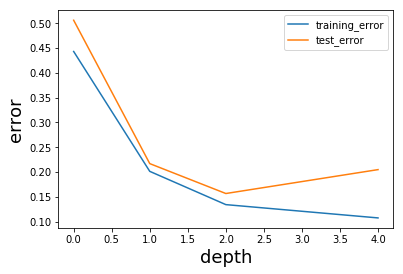

In [29]:
import matplotlib.pyplot as plt
d = np.array( [0,1,2,4] )
train_error = np.array([0.4430,0.2013,0.1342,0.1074])
test_error  = np.array([0.5060,0.2169,0.1566,0.2048])
plt.figure()
line1, = plt.plot(d,train_error)
line2, = plt.plot(d,test_error)
plt.xlabel("depth",size = 18)
plt.ylabel("error",size = 18)
plt.legend([line1, line2], ['training_error','test_error'])
plt.show()